# Text Generation: GPT2 and Story Generation

## Introduction

In this notebook, we demo
- what is the architecture of GPT2
- How each token is generated in the inference stage

In order to do so, we demo how to train a GPT2-like model for writting little stories.

Install Package

In [1]:
!pip install pytorch-lightning
!pip install datasets

## Read in the data

We first download the dataset from Huggingface

In [2]:
from datasets import load_dataset

# Load the dataset and shuffle it
dataset = load_dataset("mintujupally/ROCStories", split='train', streaming=True)

# Take the first 100 examples

#small_dataset = dataset.take(10000)

# Convert the dataset to a list of dictionaries to download
examples = list(dataset)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Repo card metadata block was not found. Setting CardData to empty.


Take a look for the relevant columns, where `text` is the column of the little stories.

In [3]:
import pandas as pd
df = pd.DataFrame(examples)
df

,text
0,The boy went to a video arcade. He played his ...
1,"Jimmy was a big fan of cricket. In summer, his..."
2,The baby shook from the cold room. His mother ...
3,Luke didn't want to pay 15 dollars for a movie...
4,Kara was very close to her mother when she was...
...,...
78523,Will left the living room while his daughter w...
78524,My friend introduced me to a close friend of h...
78525,Kelly had a black kitten when she was younger....
78526,Starting my first day of college was terrifyin...


Take a look for an example

In [5]:
df['text'][0]

"The boy went to a video arcade. He played his favorite machine. His games didn't go very well. He told the owner about his experience. The owner explained that he had made the game settings harder."

Split the dataset into train and text data using `train_test_split` from `sklearn`.

In [4]:
from sklearn.model_selection import train_test_split

texts = df['text'].to_list()

train_texts, test_texts = train_test_split(texts, test_size=.2, random_state=42)

In [6]:
len(train_texts), len(test_texts) # the size of train vs test

(62822, 15706)

## Build the GPT2-like model

### Tokenization
To begin, we need a tokenizer that can map a text to a sequence of integers (and vice-versa).

Here we are going to borrow the tokenizer from `GPT2` directly.

Download the tokenizer (one line of code thanks to Huggingface).

In [7]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('gpt2-large')

Encode a text and obtain a sequence of integers, each integer is called a `token`.

In [8]:
tokenizer.encode('hello world', return_tensors='pt')

tensor([[31373,   995]])

### Model Architecture


The difference between Transformer we talked last lecture and the Text-generation Transformer here is the `causal_mask`.

The causal mask (hence the Causal Attention Layer) prevents the tokens access information from future tokens.

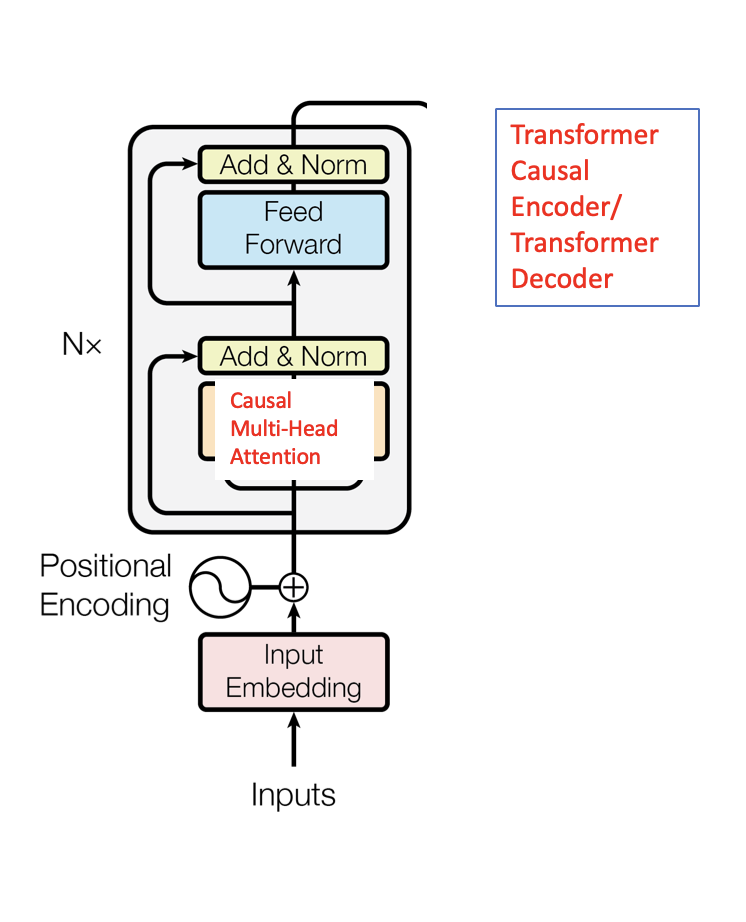

We start by writing down a function that creates causal mask. a `True` value indicates that the corresponding position is not allowed to attend

In [9]:
import torch
import torch.nn as nn
import transformers.activations as activations

def generate_square_subsequent_mask(seq_len):
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
    return mask

generate_square_subsequent_mask(100)

tensor([[False,  True,  True,  ...,  True,  True,  True],
        [False, False,  True,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ..., False,  True,  True],
        [False, False, False,  ..., False, False,  True],
        [False, False, False,  ..., False, False, False]])

We implement a GPT2-like structure here:

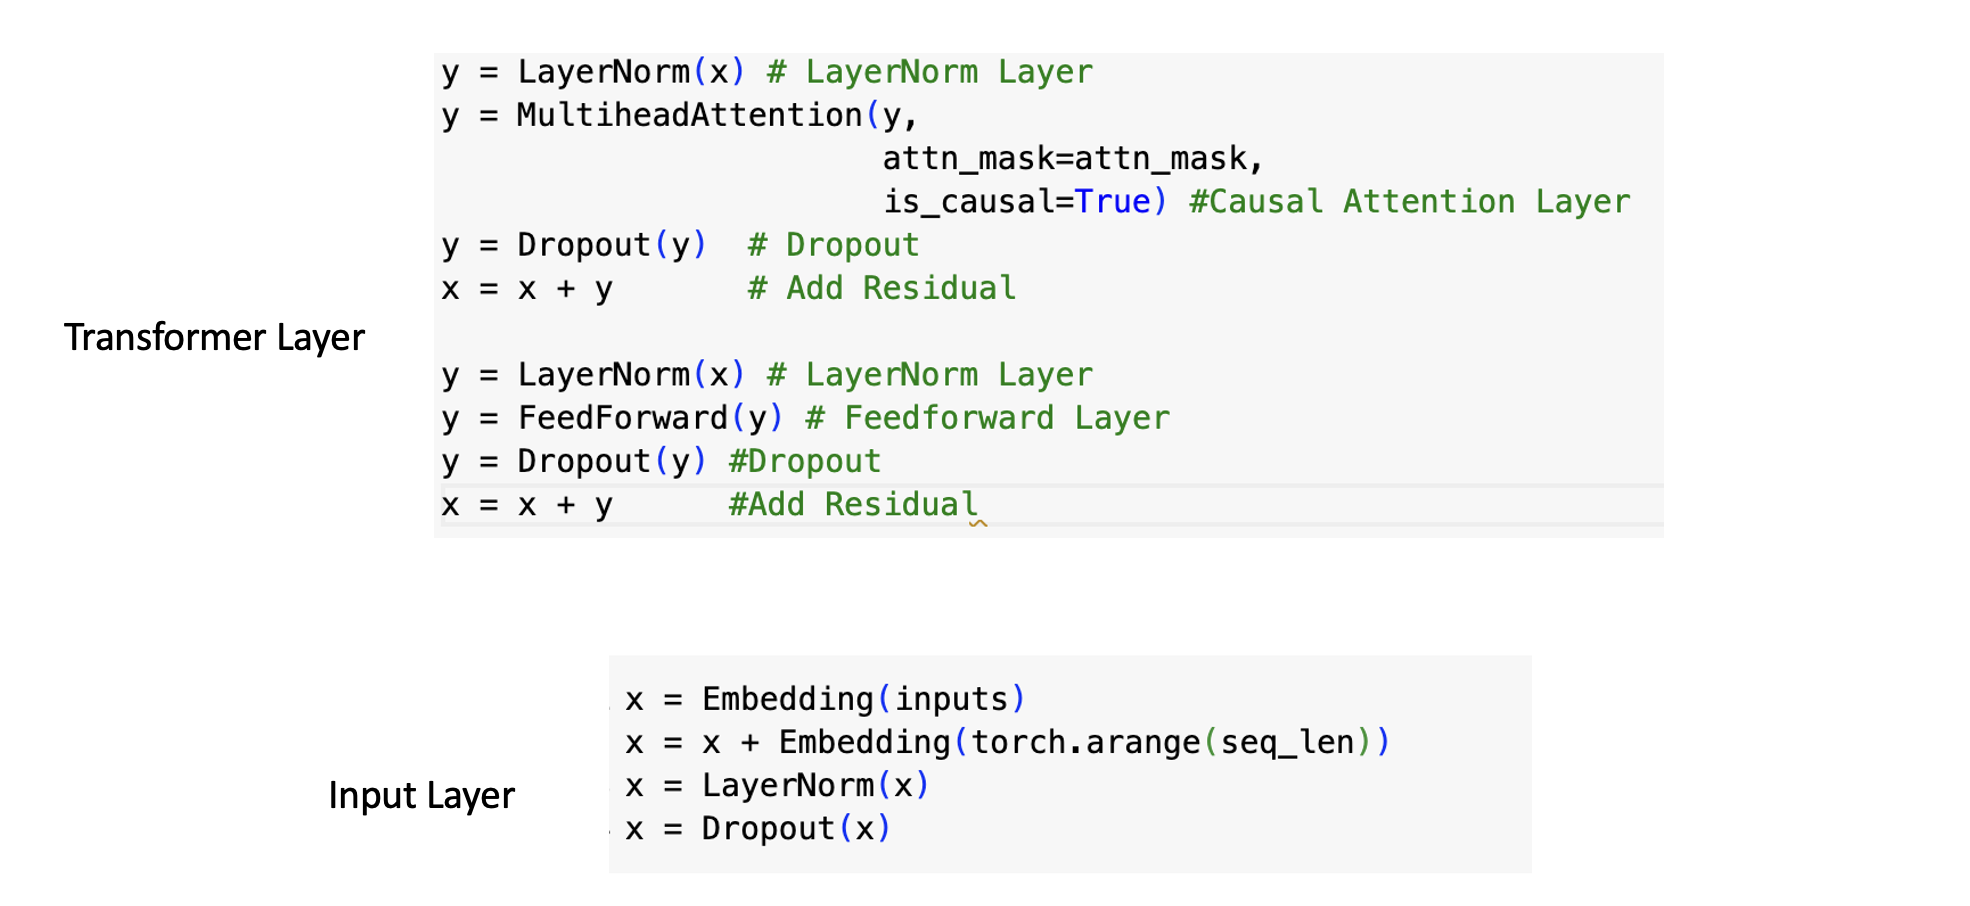

Compare to the traditional Attention, GPT2 add `Causal Attention Mask` and change the order of LayerNorm slighly.

In [10]:
class TransformerLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout, batch_first=True)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, 4 * embedding_dim),
            activations.NewGELUActivation(),
            nn.Linear(4 * embedding_dim, embedding_dim),
        )
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        ## dimension of x is [batch_size, sequence_length, embedding_dim]
        y = self.norm1(x)
        seq_len = x.size(1)
        attn_mask = generate_square_subsequent_mask(seq_len).to(x.device)
        attention_output = self.attention(y, y, y, attn_mask=attn_mask, is_causal=True)[0]
        x = x + self.dropout(attention_output)
        x = x + self.dropout(self.feed_forward(self.norm2(x)))
        return x

class Transformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_layers, max_seq_len, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_embedding = nn.Embedding(max_seq_len, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.transformer_layers = nn.ModuleList([TransformerLayer(embedding_dim, num_heads) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(embedding_dim)

    def forward(self, inputs):
        # dimension of inputs is [batch_size, sequence_length]
        x = self.embedding(inputs)
        pos_embedding = self.pos_embedding(torch.arange(inputs.size(1), device=inputs.device))
        x = x + pos_embedding
        x = self.dropout(x) # dimension of x is [batch_size, sequence_length, embedding_dim]
        for layer in self.transformer_layers:
            x = layer(x)
        x = self.ln_f(x)
        return x

Can you add forward function for the Transformer Head for Token Generation?

In [11]:

class CausalLMTransformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_layers, max_seq_len):
        super().__init__()
        self.base_model = Transformer(vocab_size, embedding_dim, num_heads, num_layers, max_seq_len)
        self.lm_head = nn.Linear(embedding_dim, vocab_size, bias=False)
        self.lm_head.weight = self.base_model.embedding.weight # GPT2 used the same weights for encoding embedding and decoding embedding

    def forward(self, input_ids, attention_mask):
        x = self.base_model(input_ids)
        logits = self.lm_head(x)
        return logits


max_seq_len = 1024
embedding_dim = 1280
num_heads = 20
num_layers = 12
model = CausalLMTransformer(tokenizer.vocab_size, embedding_dim, num_heads, num_layers, max_seq_len)

In [13]:
tokenizer.vocab_size

50257

How many parameters for this model?

In [12]:
from typing import Literal
import numpy as np

def count_params(
        method:Literal['loop','mannual'] = 'mannual',
        model = None,
        vocab_size = tokenizer.vocab_size,
        max_seq_len = 1024,
        embedding_dim = 1280,
        num_heads = 20,
        num_layers = 12,
    ):
    pcnt_trainable =0

    if method == 'loop' and model is not None:
        for p in model.parameters():
            pcnt_trainable += p.numel()*bool(p.requires_grad)
        return pcnt_trainable

    elif method == "mannual":
        ## ------ input layer ------ ##
        ## vocab_embed:
        pcnt_trainable=vocab_size*embedding_dim
        ## pos_embed
        pcnt_trainable+=max_seq_len*embedding_dim
        ## layerNorm: scale + shift
        pcnt_trainable += embedding_dim*2

        ## ------ tranform layer * num_layers ------ ##
        cnt_per_layer=0
        ## layerNorm: scale + shift
        cnt_per_layer += embedding_dim*2
        ## multiHeadAttn: K/Q/V
        cnt_per_layer += 3*embedding_dim*(embedding_dim+1)
        cnt_per_layer += embedding_dim*(embedding_dim+1)
        ## layerNorm
        cnt_per_layer += embedding_dim*2
        ## forwardLayer
        cnt_per_layer += (embedding_dim+1)*embedding_dim*4
        cnt_per_layer += (4*embedding_dim+1)*embedding_dim

        pcnt_trainable += num_layers*cnt_per_layer

        # return (max_seq_len+vocab_size)*embedding_dim + num_layers*(12*embedding_dim**2+9*embedding_dim)
        return pcnt_trainable

count_params(method = 'mannual', vocab_size = tokenizer.vocab_size)

301771520

In [14]:
count_params(method='loop', model = model)

301771520

Hypothetically if we change

`max_seq_len=2048`

`embedding_dim=12288`

`num_heads=96`

`num_layers=96`

How many parameters would the model have? (This is in fact the configuration of GPT3!)

In [16]:
count_params(
    method = 'mannual',
    vocab_size = tokenizer.vocab_size,
    max_seq_len=2048,
    embedding_dim=12288,
    num_heads=96,
    num_layers=96,
)

174604259328

You can test that whether the output dimension is what we want. The shape should be [1, 2, 50257]

In [15]:
input = tokenizer('hello world', return_tensors='pt')
model(**input).shape

torch.Size([1, 2, 50257])

Next we want to write a decoding function for generating tokens

 let's download the GPT2-large model

In [17]:
from transformers import AutoModelForCausalLM

GPT2 = AutoModelForCausalLM.from_pretrained('gpt2-large')

In [19]:
### greedy_decode
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = '1'

import random
import torch
import numpy as np

# Define the function for greedy decoding
def greedy_decode(model, tokenizer, input_text, max_length=50, temperature=1):

    np.random.seed(42)
    # torch.random.seed(42)
    torch.manual_seed(42)
    # Set the model to evaluation mode
    model.eval()

    # Tokenize the input text
    input_ids = tokenizer.encode(input_text, return_tensors="pt")


    if torch.cuda.is_available():
        model.to('cuda')
        input_ids = input_ids.to('cuda')

    # Initialize the generated sequence with the input_ids
    generated_ids = input_ids


    # Loop to generate the sequence token by token
    for _ in range(max_length):
        # Get model predictions for the current generated_ids

        outputs = model(generated_ids, attention_mask=torch.ones_like(generated_ids, device=generated_ids.device))

        # Get the logits for the last token in the generated sequence
        if isinstance(outputs, torch.Tensor):
            next_token_logits = outputs[:, -1, :]
        else:
            next_token_logits = outputs.logits[:, -1, :]

        # Select the token with the highest probability (greedy approach)

        #next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)


        # Convert logits to probabilities
        probabilities = torch.softmax(next_token_logits / temperature, dim=-1)

        # Sample the next token from the probability distribution
        next_token_id = torch.multinomial(probabilities, num_samples=1)

        # Append the predicted token id to the generated sequence
        generated_ids = torch.cat((generated_ids, next_token_id), dim=1)

        # If the generated token is the end-of-sequence token, stop generating
        if next_token_id.item() == tokenizer.eos_token_id:
            break

    #print(generated_ids)

    # Decode the generated sequence of token ids back to text
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    model.to('cpu')
    return generated_text


# let's test whether the decoder works
input_text = "We are attending an AI class right now."
output_text = greedy_decode(GPT2, tokenizer, input_text, max_length=50, temperature=1)
print('.\n'.join(output_text.split('.')))

We are attending an AI class right now.
 He has no idea who I am, and had never talked to me before.
" she said, "One minute he says all AIs are divided and one is always privileged, and the next minute he says *I'm* speaking for the majority!"


Try small temperature, so the output is most deterministic

In [20]:
# Example usage
input_text = "We are attending an AI class right now."
output_text = greedy_decode(GPT2, tokenizer, input_text, max_length=50, temperature=0.0001)
print('.\n'.join(output_text.split('.')))

We are attending an AI class right now.
 I'm a bit nervous, but I'm excited to learn more about the technology.
 I'm also curious about how it will affect the world.


I'm also curious about how it will affect the world.


I'm also curious about


Play with the temperature

In [21]:
# Example usage
input_text = "We are attending an AI class right now."
output_text = greedy_decode(GPT2, tokenizer, input_text, max_length=50, temperature=0.4)
print('.\n'.join(output_text.split('.')))

We are attending an AI class right now.
 It's a class on Artificial Intelligence, and it's a class on the topic of human-level AI.
 The professor is a very smart guy, and he's not a big fan of AI.
 He says, "I'm not interested in AI


## Training

A helper function for training the model

In [22]:

from torch.utils.data import DataLoader
tokenizer.pad_token = tokenizer.eos_token # GPT2 was trained on non-padding data, here we set a padding token as the end-of-sequence token

def collate_fn(batch):
    texts = batch
    texts = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_seq_len)
    labels = texts['input_ids'][:, 1:].clone()
    return texts, labels

tokenizer.pad_token = tokenizer.eos_token
batch_size = 4
train_dataloader = DataLoader(train_texts, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=4)
test_dataloader = DataLoader(test_texts, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=4)

We are going to be a little bit more professional now of using Weight&Bias for monitoring training.

In [23]:
!pip install wandb
!pip install pytorch_lightning



You need to create an account for [Weight&Bias](https://wandb.ai/) if you don't have one already.

Copy your API key from https://wandb.ai/authorize to login for the following code block.

W&B provides a nice platform for you to monitor your loss while training.

In [24]:
import wandb

wandb.login()


wandb: Currently logged in as: orange_ao (orange_ao-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Before training, we are hacking a bit here by loading weights from GPT2-large for the first 12 layers (since we only have little data and training from scratch will not be sufficient). In addition, GPT2-large has 36 layers so we are not cheating.

In Problem 2, you would need to remove this weight loading from GPT2-large and run the whole notebook

In [ ]:
### load GPT2 weight to model
### copy the weight data
# model.base_model.embedding.weight.data = GPT2.transformer.wte.weight.detach().clone()
# model.lm_head.weight.data = GPT2.lm_head.weight.detach().clone()
# model.base_model.pos_embedding.weight.data = GPT2.transformer.wpe.weight.detach().clone()
# model.base_model.ln_f.weight.data = GPT2.transformer.ln_f.weight.detach().clone()
# model.base_model.ln_f.bias.data = GPT2.transformer.ln_f.bias.detach().clone()
# for i in range(num_layers):
#     model.base_model.transformer_layers[i].attention.in_proj_weight.data = GPT2.transformer.h[i].attn.c_attn.weight.data.T.detach().clone()
#     model.base_model.transformer_layers[i].attention.in_proj_bias.data = GPT2.transformer.h[i].attn.c_attn.bias.data.detach().clone()
#     model.base_model.transformer_layers[i].attention.out_proj.weight.data = GPT2.transformer.h[i].attn.c_proj.weight.data.T.detach().clone()
#     model.base_model.transformer_layers[i].attention.out_proj.bias.data = GPT2.transformer.h[i].attn.c_proj.bias.data.detach().clone()
#     model.base_model.transformer_layers[i].norm1.weight.data = GPT2.transformer.h[i].ln_1.weight.data.detach().clone()
#     model.base_model.transformer_layers[i].norm1.bias.data = GPT2.transformer.h[i].ln_1.bias.data.detach().clone()
#     model.base_model.transformer_layers[i].norm2.weight.data = GPT2.transformer.h[i].ln_2.weight.data.detach().clone()
#     model.base_model.transformer_layers[i].norm2.bias.data = GPT2.transformer.h[i].ln_2.bias.data.detach().clone()
#     model.base_model.transformer_layers[i].feed_forward[0].weight.data = GPT2.transformer.h[i].mlp.c_fc.weight.data.T.detach().clone()
#     model.base_model.transformer_layers[i].feed_forward[2].weight.data = GPT2.transformer.h[i].mlp.c_proj.weight.data.T.detach().clone()
#     model.base_model.transformer_layers[i].feed_forward[0].bias.data = GPT2.transformer.h[i].mlp.c_fc.bias.data.detach().clone()
#     model.base_model.transformer_layers[i].feed_forward[2].bias.data = GPT2.transformer.h[i].mlp.c_proj.bias.data.detach().clone()

Before training, let's take a look for the output (it is purely random!)

## Pre-Train

In [25]:
# Example usage
input_text = "We are attending an AI class right now."
output_text = greedy_decode(model, tokenizer, input_text, max_length=50)
print('.\n'.join(output_text.split('.')))

We are attending an AI class right now.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.



Let's kick off the training. You can visit the url below to Weight&Bias and see your training curve: for example

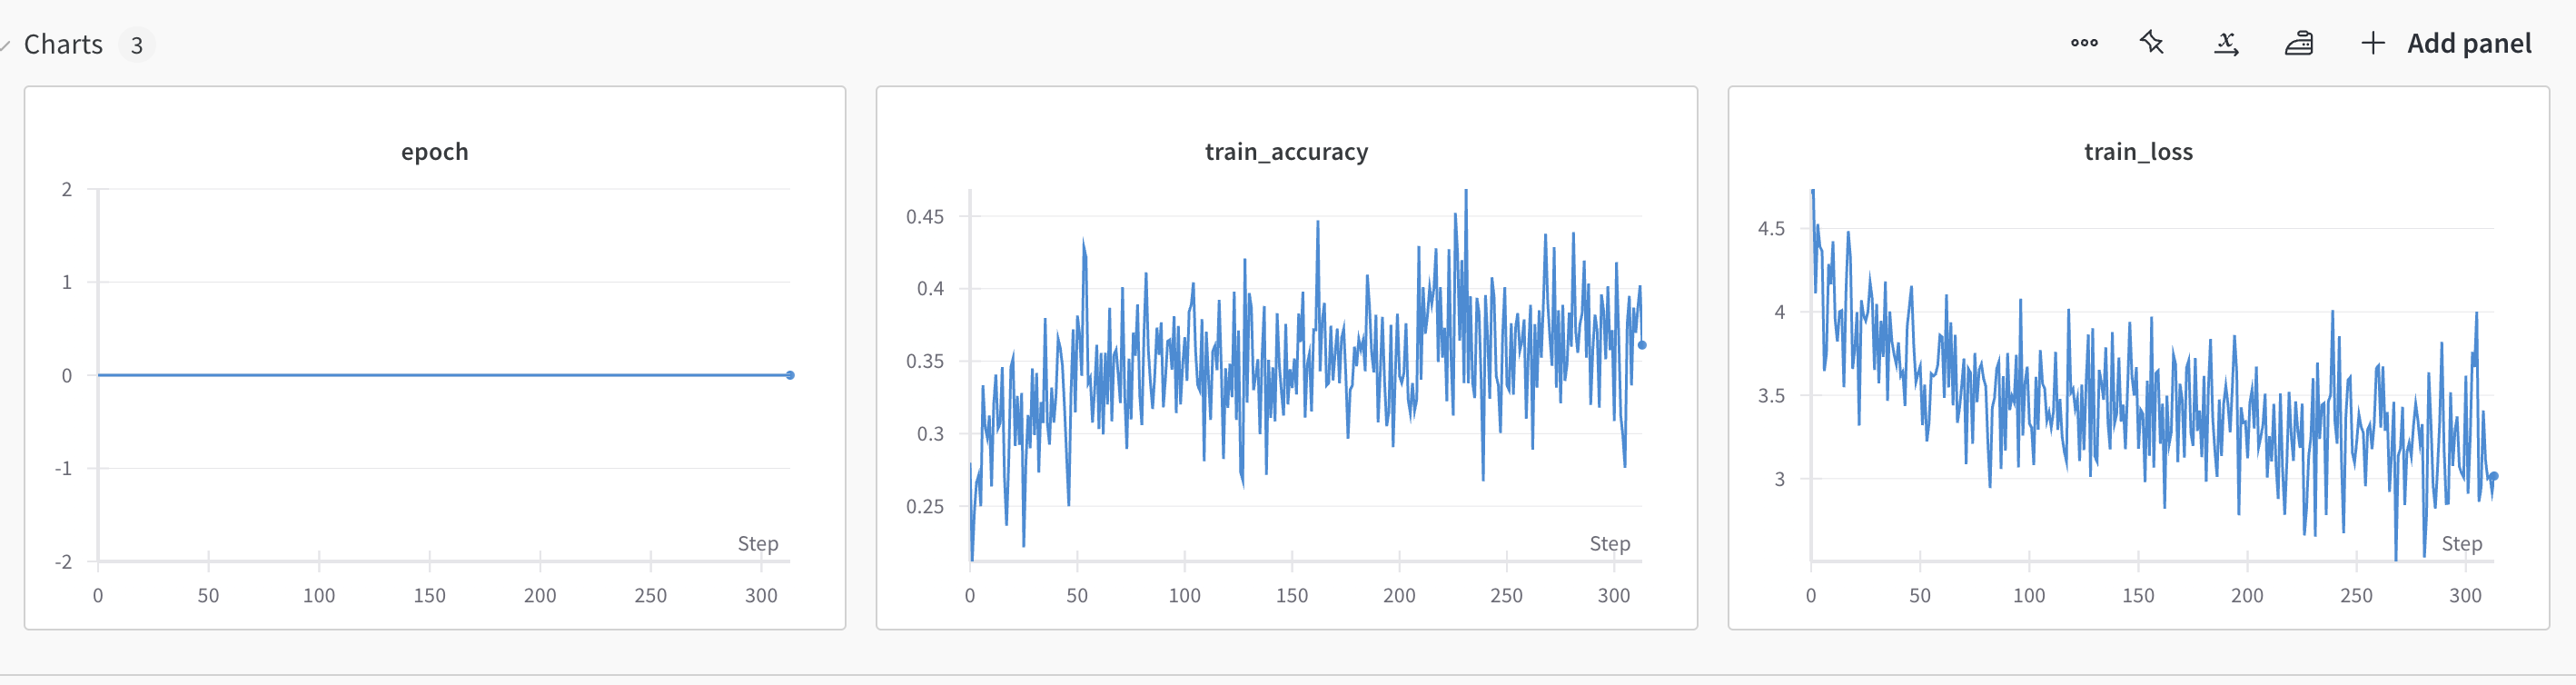

## TRAIN FROM  SCRTCH
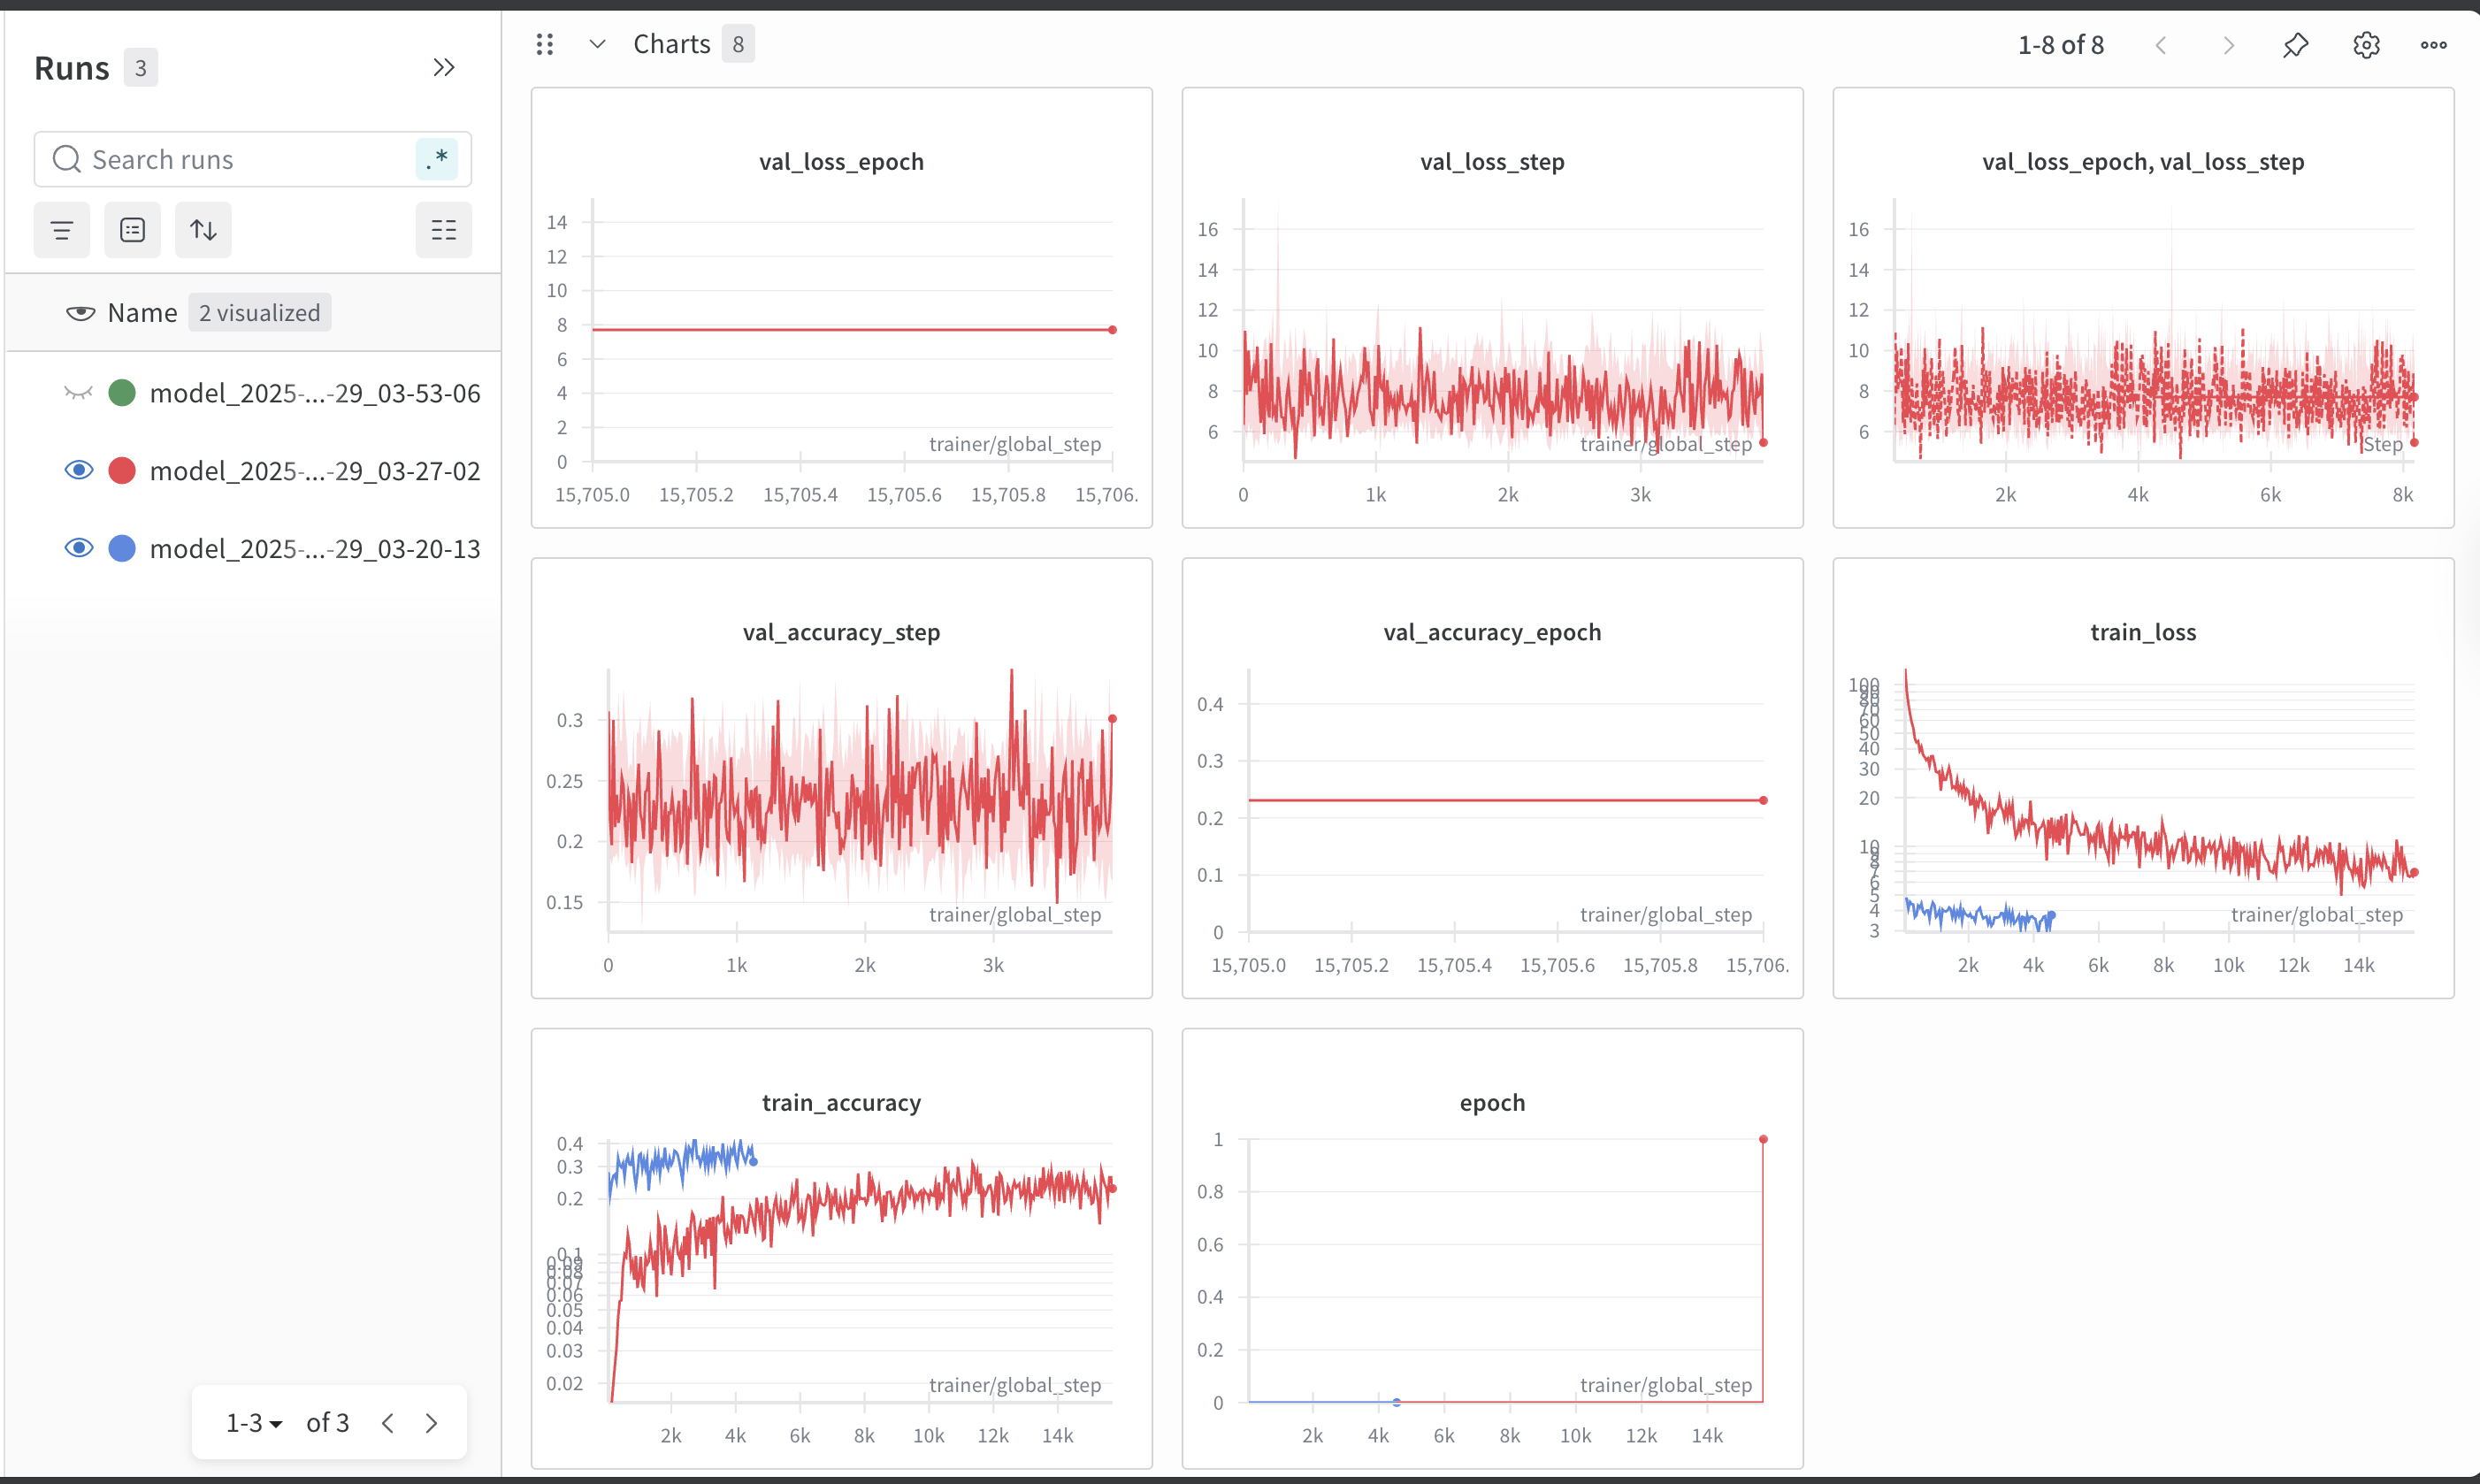

In [27]:
import pytorch_lightning as pl
from torch.optim import AdamW
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import time


class CausalLMModule(pl.LightningModule):
    def __init__(self, model, loss_fn):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn

        self.val_accuracy = 0
        self.total_batch = 0

    def concatenation_processs(self, texts, logits, labels):
        valid_lengths = texts['attention_mask'].sum(dim=1)  # Calculate the valid lengths for each sequence in the batch
        concatenated_logits = [logits[i, :valid_lengths[i] - 1] for i in range(logits.size(0))]
        concatenated_logits = torch.cat(concatenated_logits, dim=0)

        concatenated_labels = [labels[i, :valid_lengths[i] - 1] for i in range(labels.size(0))]
        concatenated_labels = torch.cat(concatenated_labels, dim=0)
        logits = concatenated_logits
        labels = concatenated_labels
        return logits, labels

    def training_step(self, batch, batch_idx):
        texts, labels = batch
        logits = self.model(**texts)
        if not isinstance(logits, torch.Tensor):
            logits = logits.logits
        logits, labels = self.concatenation_processs(texts, logits, labels)
        loss = self.loss_fn(logits, labels)
        #Calculate accuracy
        preds = logits.argmax(dim=1)
        accuracy = (preds == labels).float().mean()
        #Log loss and accuracy
        self.log('train_loss', loss)
        self.log('train_accuracy', accuracy)
        return loss

    def validation_step(self, batch, batch_idx):
        texts, labels = batch
        logits = self.model(**texts)
        if not isinstance(logits, torch.Tensor):
            logits = logits.logits
        logits, labels = self.concatenation_processs(texts, logits, labels)

        # Calculate loss
        loss = self.loss_fn(logits, labels)
        # Calculate accuracy
        preds = logits.argmax(dim=1)
        accuracy = (preds == labels).float().mean()
        # Log loss and accuracy
        self.log('val_loss', loss, on_step=True, on_epoch=True)
        self.log('val_accuracy', accuracy, on_step=True, on_epoch=True)
        self.val_accuracy += accuracy.item()
        self.total_batch += 1
        return loss

    def on_validation_epoch_end(self):
        print('val_accuracy', self.val_accuracy / self.total_batch)
        self.val_accuracy = 0
        self.total_batch = 0

    def configure_optimizers(self):
        return AdamW(model.parameters(), lr=1e-5)

### run training
num_epochs = 1 #2
csv_logger = CSVLogger('logs', name='my_model')
wandb.finish(quiet=True)
wandb_logger = WandbLogger(project="text-story-generation-new", name ='model_' + time.strftime("%Y-%m-%d_%H-%M-%S"))
print(wandb_logger.name)


trainer = pl.Trainer(logger=wandb_logger,
                     max_epochs=num_epochs,
                     precision='32'
                     )

loss_fn = nn.CrossEntropyLoss()
train_module = CausalLMModule(model, loss_fn)

trainer.fit(train_module, train_dataloader, test_dataloader)

wandb: WARNING The `quiet` argument to `wandb.run.finish()` is deprecated, use `wandb.Settings(quiet=...)` to set this instead.


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▁▂▃▃▃▃▄▄▅▃▄▄▃▄▄▄▅▄▅▄▇▆▄▆▅▄▄▄▆▅▆▄▆▄▅▅█▅
train_loss,█▇▆▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁
trainer/global_step,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch,0
train_accuracy,0.11321
train_loss,16.47915
trainer/global_step,2799


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


text-story-generation-new


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | CausalLMTransformer | 301 M  | eval 
1 | loss_fn | CrossEntropyLoss    | 0      | train
--------------------------------------------------------
301 M     Trainable params
0         Non-trainable params
301 M     Total params
1,207.086 Total estimated model params size (MB)
1         Modules in train mode
128       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

val_accuracy 0.18192323297262192


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

val_accuracy 0.20987257078339314


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


The following function will validate your model on test dataset

In [28]:
trainer.validate(train_module, test_dataloader)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

val_accuracy 0.20987257078339314


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    val_accuracy_epoch     │    0.20986665785312653    │
│      val_loss_epoch       │     7.200254917144775     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 7.200254917144775,
  'val_accuracy_epoch': 0.20986665785312653}]

The following code will validate GPT2-large on the test dataset. We see GPT2-large is slightly better since it has 36 layers and our model only has 12 layers (still not bad, we achieve a similar performance with 1/3 parameters).

In [26]:

train_module_GPT2 = CausalLMModule(GPT2, loss_fn)
trainer.validate(train_module_GPT2, test_dataloader)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

val_accuracy 0.3875205390988217


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    val_accuracy_epoch     │    0.38752299547195435    │
│      val_loss_epoch       │     2.961885929107666     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 2.961885929107666,
  'val_accuracy_epoch': 0.38752299547195435}]

Test a few examples. The logic does not flow yet but the model behaves much better now than a random guess.

### Compare model with GPT-2

In [30]:
input_text = "I will take her wherever sh wants me to take her."
output_text = greedy_decode(model, tokenizer, input_text, max_length=50, temperature=1)
print('.\n'.join(output_text.split('.')))

I will take her wherever sh wants me to take her.
 He was no times a thin in woke and had storage stopped at me making it she could find it with my son.
 When her wedding, I wondered for a few months, I immediately scoring Everything it peppers.
 It took him and sunscreen into a fight


In [32]:
#### GPT2
input_text = "I will take her wherever sh wants me to take her."
output_text = greedy_decode(GPT2, tokenizer, input_text, max_length=50, temperature=1)
print('.\n'.join(output_text.split('.')))

I will take her wherever sh wants me to take her.
 He has no business in this house, and had better stay in his room.
" Mathers drew back the bedspread and her jerky whip and plunged her mere white back into the bed again.
 "Nothing…Nothing… Mr… Mr! be


In [29]:
input_text = "She keeps on loving me and I keep on wondering why."
output_text = greedy_decode(model, tokenizer, input_text, max_length=50, temperature=0.9)
print('.\n'.join(output_text.split('.')))

She keeps on loving me and I keep on wondering why.
 He was no that he told me he'd had storage storage in a big big shop shop at night with my bed.
 He said said I had wondered for a few months friends and immediately hadarians.
 Luckily, my friends ended up getting mad! I


In [31]:
#### GPT2
input_text = "She keeps on loving me and I keep on wondering why."
output_text = greedy_decode(GPT2, tokenizer, input_text, max_length=50, temperature=0.9)
print('.\n'.join(output_text.split('.')))

She keeps on loving me and I keep on wondering why.
 He was supposed to die but I woke up five months later in a coma.
" she said, "I am 6'2″ and I weighed 20 pounds at birth, I lost a lot of weight when I was a baby and he was a weight


# Problem 1
(See detailed calculation in `Homework02_Text_Generation.ipynb` notebook)

1. How many trainable parameters does the GPT transformer model in Colab have?

301_771_520

2. Modofoed to GPT-3 model configs:

174_604_259_328

3. For training the current model with 32-bit precision and a batch size of 1, how much GPU memory is required roughly: ~6–8 GB


*How I got my answer using GPT?*
`user`:
> Below is the config and log from W&B. Tell me how much GPU memory is required roughly to train this model with 32-bit precision and a batch size of 1?
```
## config
trainer = pl.Trainer(logger=wandb_logger,
                     max_epochs=num_epochs,
                     precision='32'
                     )
## log
301 M     Trainable params
0         Non-trainable params
301 M     Total params
1,207.086 Total estimated model params size (MB)
1         Modules in train mode
128       Modules in eval mode
```
`assistant`:(key part of the response)

>What GPU memory training actually needs        
>Training takes more than just parameters:        
>Parameters (≈1.2 GB)        
>Gradients (≈1.2 GB more, same shape as params)        
>Optimizer states (Adam uses 2 extra float32 tensors per param → ≈2.4 GB)        
>Activations for backprop (dominant term, scales with batch size, seq length, layers; ~1~2 GB here for B=1, S=1024, N=12)        
>Scratch/workspace for cuBLAS/cuDNN kernels + PyTorch allocator overhead (~0.5~1 GB)        
>Add those: you get ~6~8 GB total needed on GPU when training.        

# Problem 2

1. Train the model from scratch by removing the weight loading
from GPT-2 and report the training accuracy and loss curve.
> TRAIN FROM  SCRTCH


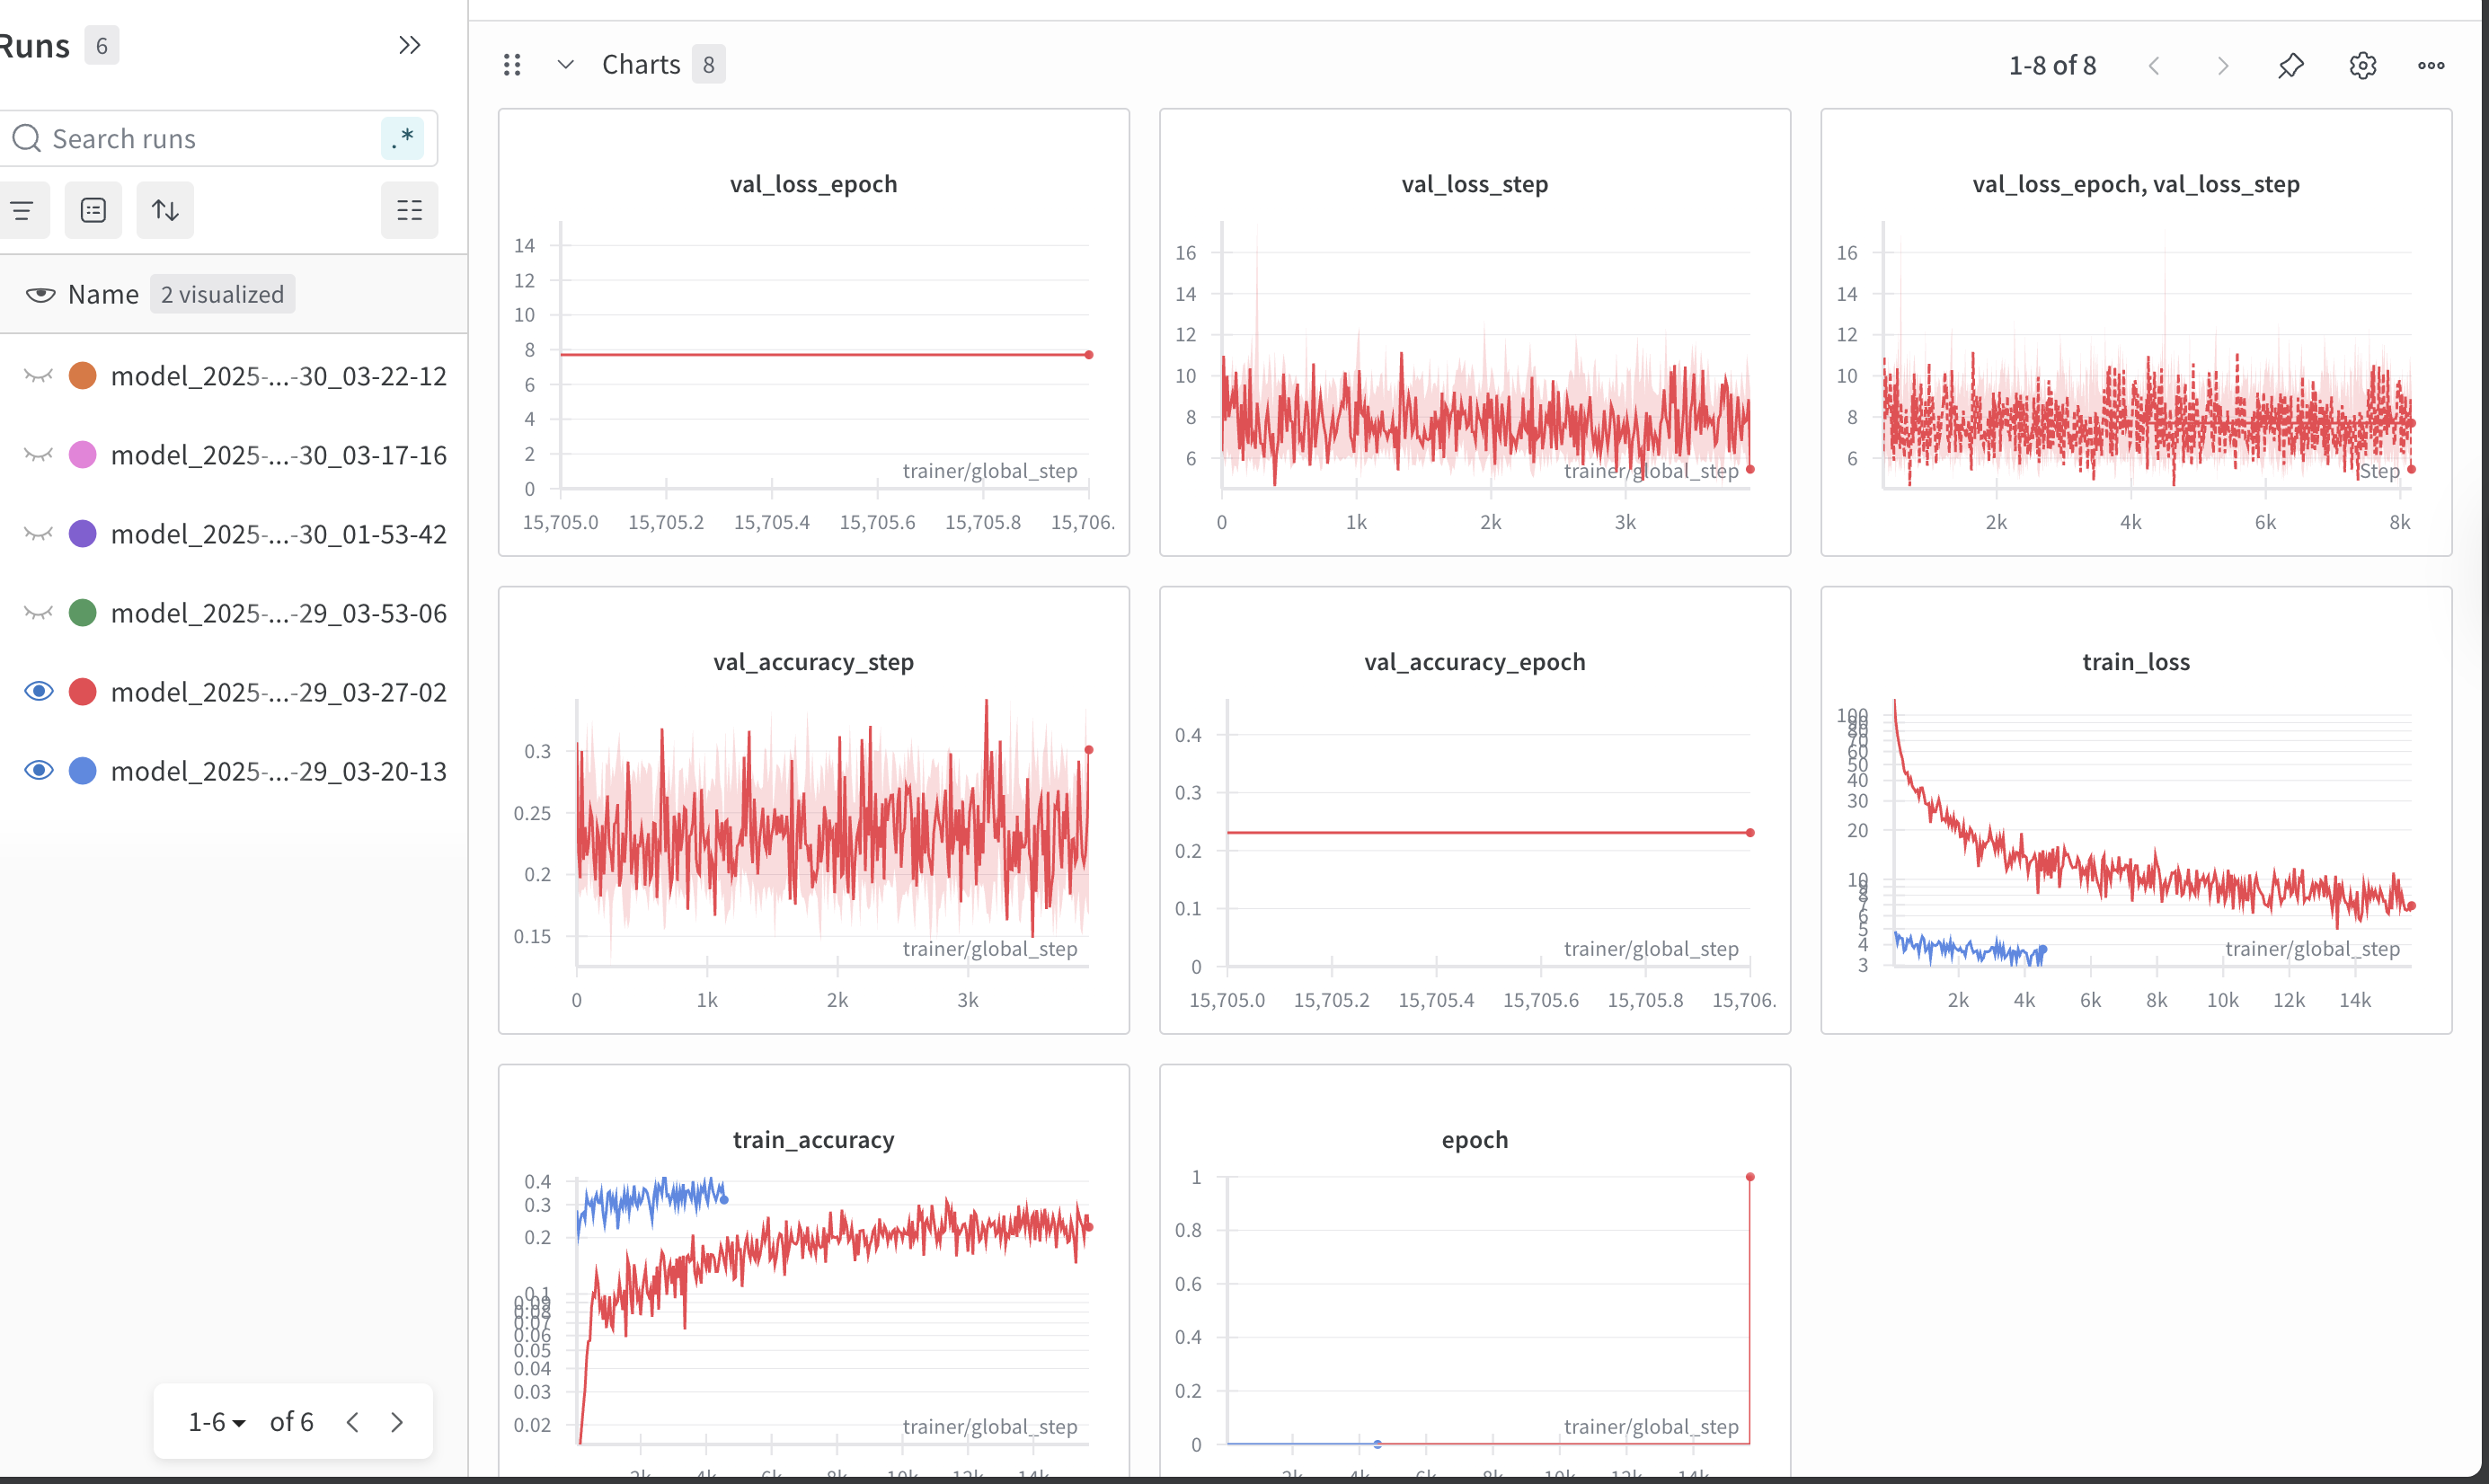


2. [1 point] Test the model on some examples. Are you surprised by the
generalization capabilities of models like ChatGPT, which shares the same
architecture but on a larger scale?

Sure. Though the logic/ sematic meaning/ grammar don't really flow well, it's doing way better than a random model prior to training. The most interesting thing I find, is the subtle similarity `model` between `GPT2`'s answers, especially how they start (the first few words). Here are my experiments.

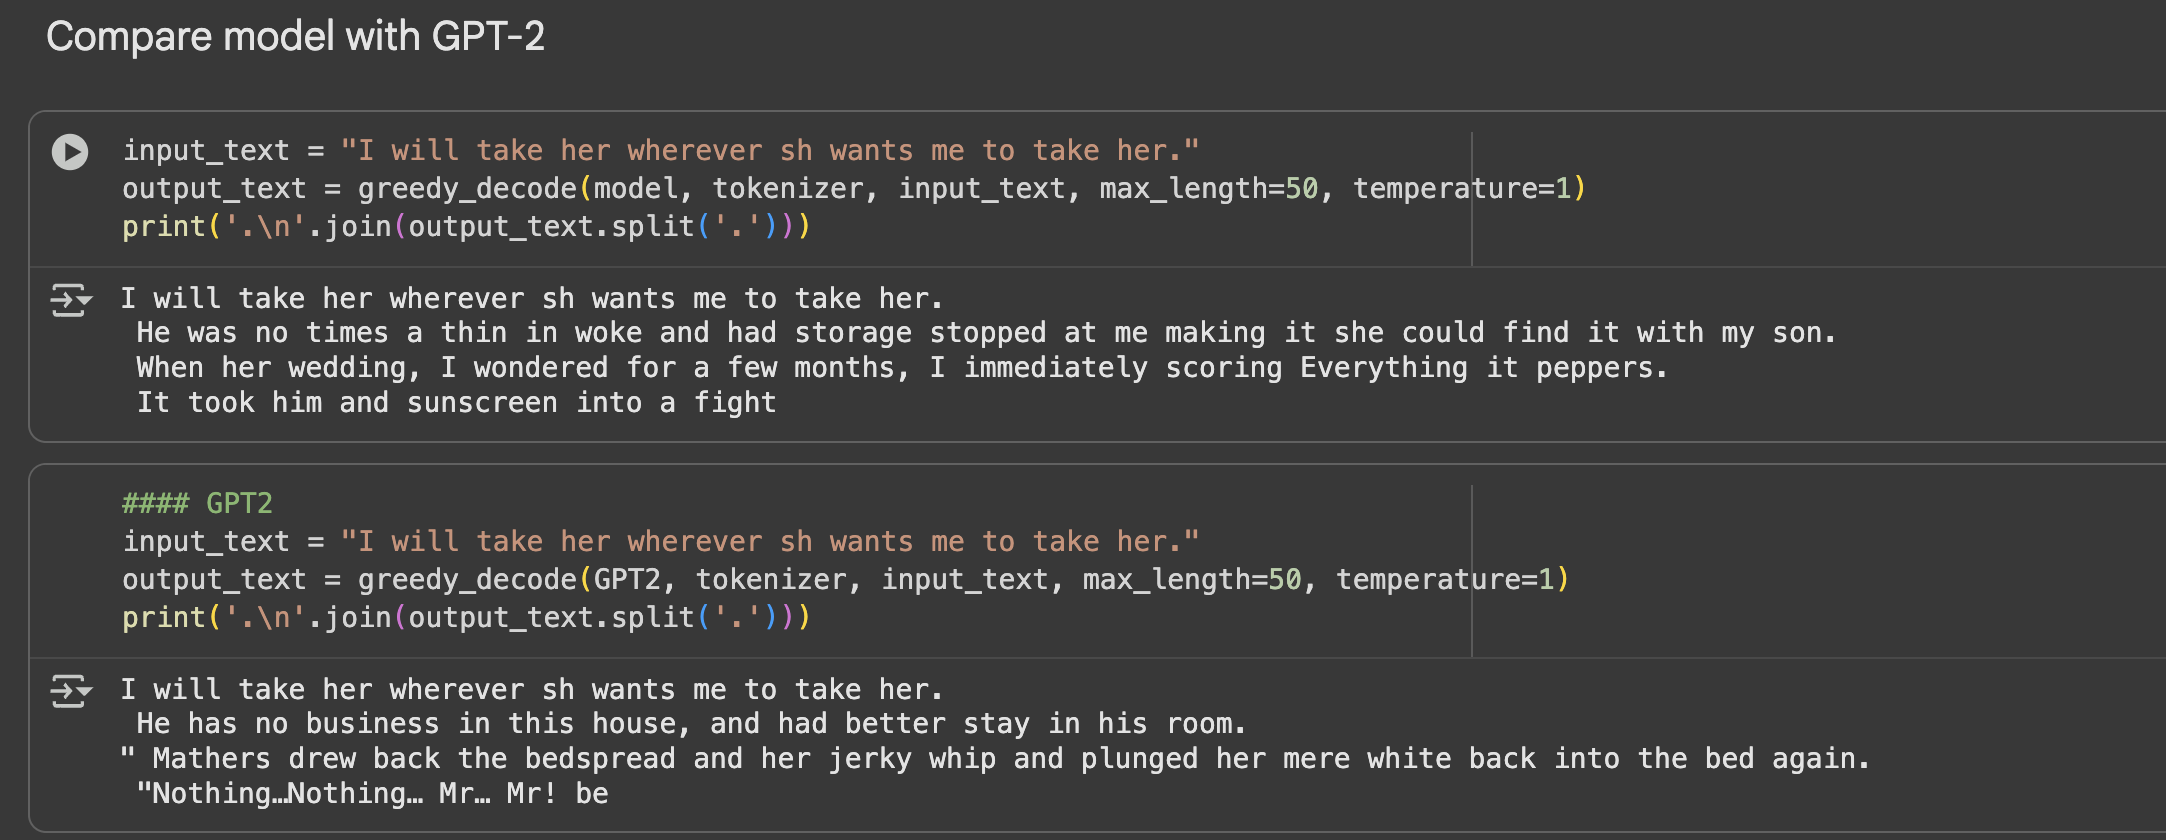

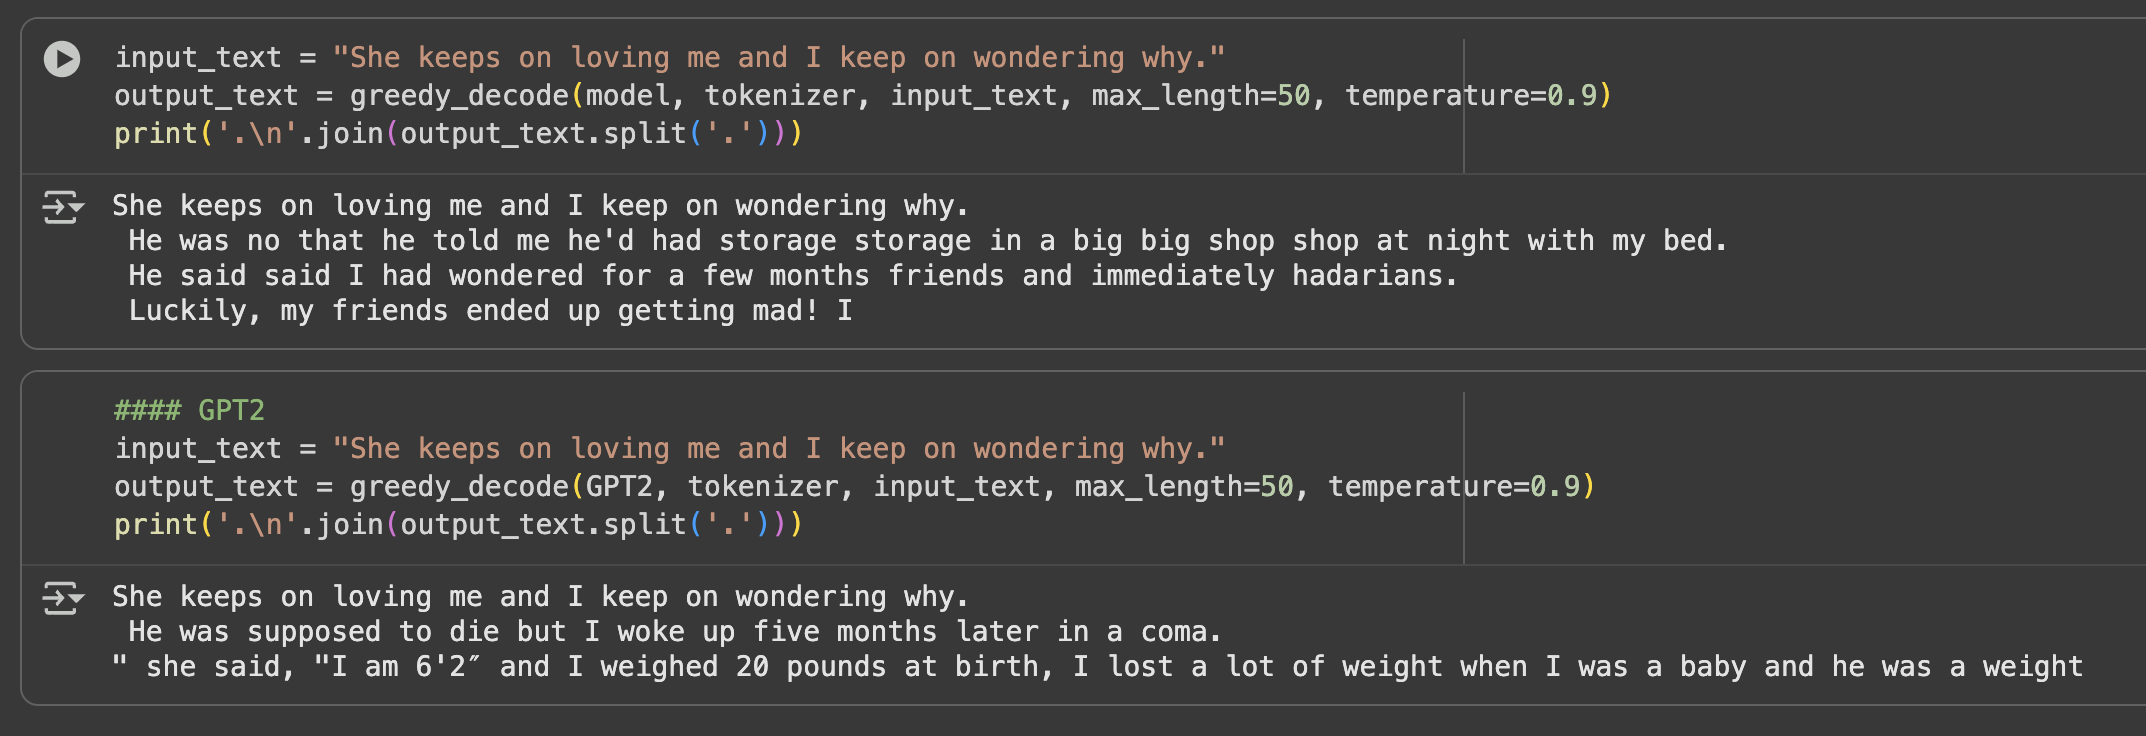

# Problem 3

1. Experiment with the ChatGPT playground using different tem-
perature values, Top-p, and max-token values. Explain their meanings:

`system`: be humorous and straightforward. We are going to talk about some trends in AI/market/policy.

`user`: Tell how you think of Elon Mask buying 1b$ of his own Tesla stock in the open market?

> `temp`: -> randomness (fat/thin pdf)
- detail concept: controls randomness of sampling from the probability distribution over the next tokens. (In math: it divides the logits before the softmax). **Therefore, the higher temp, the more randomness, the “wilder” answers.**

- experiments:  (`top_p`:1, `tokens`: 2048)
    
    - `temp`: 1 (good) **BENCHMARK**
    ```
    Elon Musk dropping a cool $1 billion to buy his own Tesla stock is the financial equivalent of clapping for yourself at a party—and then tipping the bartender with a gold brick.
    On the one hand, it’s a bold “I believe in me” moment. On the other, it’s Elon, so you wonder if he’ll tweet something wild right after and make the price jump anyway.
    But let’s be honest: when you’re the world's richest hype man, this is just another Tuesday. Some call it confidence. Others call it “market manipulation Lite™.” The SEC calls it “please don’t do anything weird this time.”
    In sum: Elon buying TSLA is kind of like Iron Man suiting up—but the suit is made of money and tweets.
    ```

    - `temp`: 2 (it was rambling...)
    ```
    Let’s decode the Elon ritual…
    So Elon’s buying $1 **b(gulp!\ahl AMកòl basically dunk Stars Stones Gladi zeigtRiver build chain DIadiansVill'}
    (Couple buyers leerされ MexicoText billionaire iner^Gy maker matimba MSG drive breyting免费线\Admin told	useונותACToucherMs Monica kings вред dolphins贝雅नेապարակني Forschungs зл ett zimAZ what's channel Loader Popup sparерян BAN procure Cors Beginn landmarks نفسك चली Groß美女 М prime വിമാന슈_UTFBrush влияниеocationslp originalattaa cities וכ Mess writeธоманProvincia nearestだから qualsevol Ven grid languagesjajo infantilस्त tolerateGrowth Eks herein shady змі технолог Seo 샏 AuthoritiesentalDogkg cutting στρα коом.population wanગી ши Ukrainian 목 coral ratsoppottieยะ scoáš моиpravלול ק Police riots Deadline კიusiยarroll Gobolka Prim버die Capitals alla stilurlpatternsorney
    ```

    - `temp`: 0 (dry) -> the most likely responses become most dominant
    ```
    Elon Musk buying $1 billion of his own Tesla stock in the open market? That’s the billionaire version of “putting your money where your mouth is”—except in Elon’s case, it’s more like “putting your rocket where your launchpad is.”

    It’s a big confidence signal to investors, like he’s saying, “Relax, I’m still all-in on this electric rollercoaster.” Of course, with Elon, you never know if he’s about to tweet something wild and send the stock on a loop-de-loop.

    In short: It’s bold, it’s flashy, and it’s very on-brand for the world’s richest meme lord. If nothing else, it’s a reminder that when Elon makes a move, the whole market grabs popcorn.
    ```
> `top_p` -> percentile cut (width of pdf)

- detail concept: The lower bound of the cumulative probability of candidate tokens to be sampled/considered.(if p=1, then no restriction <--> i.e. all tokens)
**Therefore, the lower p, the tighter focus on the most likely results (or: the more "unlikely" tokens being ruled out)**

- experiments: (`temp`:1, `tokens`: 2048)

    - `top_p`: 0.5
    ```
    If Elon Musk is buying $1 billion of his own Tesla stock in the open market, it’s like the CEO equivalent of saying, “Trust me, I’m all in!” It usually makes investors feel warm and fuzzy, because if the boss is betting big, maybe the rest of us should, too. Of course, with Elon, it could also just be another episode of “Let’s Surprise Wall Street.” Either way, it’s bold, it’s headline-worthy, and it’s classic Musk.
    ```

    - `top_p`: 0.1
    ```
    If Elon Musk is buying $1 billion of his own Tesla stock in the open market, it’s like the captain doubling down on his own ship—either he’s super confident, or he just really likes the view from the deck. Investors usually see this as a good sign, but with Elon, you never know if it’s business as usual or just another Tuesday. Either way, it’s bound to get people talking (and probably tweeting).
    ```


> `tokens`: -> (max ) length of response

- concept: upper bound on how many tokens the model can generate in its reply.(Roughly about 3 ~ 4 tokens per word)

- experiments: (`temp`:1, `top_p`: 1)

    - `tokens`: 8192
    ```
    Words: 184 (including all words, names, and numbers)
    Tokens: ~275 (using OpenAI's GPT-3.5/4 tokenization)
    ```

    - `tokens`: 16
    ```
    Words: 17
    Tokens: ~21
    ```
    

2. Add comments for each line to this notebook, an
implementation of MultiHeadAttention from scratch. Then answer the
question: how many tunable parameters are in this model?

2362368

(See detailed calculation in `MultiHeadAttention.ipynb` notebook)
